In [2]:
# Data Preprocessing
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek
import joblib

# =========================
# 1. Load dataset
# =========================
file_path = r"C:\Users\Shimmula Varshini\Downloads\archive (5)\kidney_disease_dataset.csv"
df = pd.read_csv(file_path)

# =========================
# 2. Drop duplicates
# =========================
df.drop_duplicates(inplace=True)

# =========================
# 3. Handle missing values
# =========================
df.fillna(df.median(numeric_only=True), inplace=True)

# =========================
# 4. Encode categorical variables
# =========================
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# =========================
# 5. Separate features and target
# =========================
X = df.drop(columns=['Target'])
y = df['Target']

# =========================
# 6. Apply SMOTETomek
# =========================
smt = SMOTETomek(random_state=42)
X_resampled, y_resampled = smt.fit_resample(X, y)

print("Before balancing:\n", y.value_counts())
print("\nAfter SMOTETomek:\n", y_resampled.value_counts())

# =========================
# 7. Scale features
# =========================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)
joblib.dump(scaler, "scalerf.pkl")

# =========================
# 8. Train-test split
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# =========================
# 9. Save preprocessed datasets
# =========================
joblib.dump(label_encoders, "label_encodersf.pkl")

joblib.dump(X_train, "X_trainf.pkl")
joblib.dump(X_test, "X_testf.pkl")
joblib.dump(y_train, "y_trainf.pkl")
joblib.dump(y_test, "y_testf.pkl")
print("Dataset contents")
print(df.head(5))
print("\nPreprocessing complete. Train/test data and objects saved successfully!")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train distribution:\n", y_train.value_counts(normalize=True))


Before balancing:
 Target
3    16432
1     2054
2      821
0      821
4      410
Name: count, dtype: int64

After SMOTETomek:
 Target
4    16411
0    16388
2    16383
1    16339
3    16241
Name: count, dtype: int64
Dataset contents
   Age of the patient  Blood pressure (mm/Hg)  Specific gravity of urine  \
0                  54                     167                      1.023   
1                  42                     127                      1.023   
2                  38                     148                      1.016   
3                   7                      98                      1.017   
4                  67                     174                      1.015   

   Albumin in urine  Sugar in urine  Red blood cells in urine  \
0                 1               4                         1   
1                 3               2                         1   
2                 0               0                         0   
3                 4               0                

In [3]:
#-----Random Forest Classification-----
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, f1_score
import joblib

#1. Load preprocessed train/test data
X_train = joblib.load("X_trainf.pkl")
X_test = joblib.load("X_testf.pkl")
y_train = joblib.load("y_trainf.pkl")
y_test = joblib.load("y_testf.pkl")
# Parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Random Forest with class_weight balanced
rf = RandomForestClassifier(class_weight="balanced", random_state=42)

# GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring="f1_macro"
)

grid_search.fit(X_train, y_train)

# Best RF model
best_rf = grid_search.best_estimator_
print("Best Parameters (RF):", grid_search.best_params_)
print("Best CV Score (RF):", grid_search.best_score_)

# Evaluate on test set
y_pred_best_rf = best_rf.predict(X_test)

print("\nClassification Report (Best RF):\n", classification_report(y_test, y_pred_best_rf))
print("Test Accuracy (RF):", accuracy_score(y_test, y_pred_best_rf))
print("Balanced Accuracy (RF):", balanced_accuracy_score(y_test, y_pred_best_rf))
print("Macro F1 Score (RF):", f1_score(y_test, y_pred_best_rf, average="macro"))
########
joblib.dump(best_rf, "random_forest_modelff.pkl")
print("\n Model saved as 'random_forest_modelff.pkl'")


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters (RF): {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best CV Score (RF): 0.9416219456597383

Classification Report (Best RF):
               precision    recall  f1-score   support

           0       1.00      0.96      0.98      3278
           1       0.94      0.90      0.92      3268
           2       1.00      0.96      0.98      3277
           3       0.83      0.94      0.89      3248
           4       1.00      0.98      0.99      3282

    accuracy                           0.95     16353
   macro avg       0.95      0.95      0.95     16353
weighted avg       0.95      0.95      0.95     16353

Test Accuracy (RF): 0.9493059377484253
Balanced Accuracy (RF): 0.9492584357770264
Macro F1 Score (RF): 0.9501526160271785

 Model saved as 'random_forest_modelff.pkl'


In [4]:
#-----xgboost-----
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, f1_score
import joblib

#1. Load preprocessed train/test data
X_train = joblib.load("X_trainf.pkl")
X_test = joblib.load("X_testf.pkl")
y_train = joblib.load("y_trainf.pkl")
y_test = joblib.load("y_testf.pkl")

# Parameter grid

# Parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# XGBClassifier (using scale_pos_weight to handle imbalance if needed)
xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=len(y_train.unique()),  # number of classes
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

# GridSearchCV
grid_search_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring="f1_macro"
)

# Fit model
grid_search_xgb.fit(X_train, y_train)

# Best XGB model
best_xgb = grid_search_xgb.best_estimator_
print("Best Parameters (XGB):", grid_search_xgb.best_params_)
print("Best CV Score (XGB):", grid_search_xgb.best_score_)

# Evaluate on test set
y_pred_best_xgb = best_xgb.predict(X_test)

print("\nClassification Report (Best XGB):\n", classification_report(y_test, y_pred_best_xgb))
print("Test Accuracy (XGB):", accuracy_score(y_test, y_pred_best_xgb))
print("Balanced Accuracy (XGB):", balanced_accuracy_score(y_test, y_pred_best_xgb))
print("Macro F1 Score (XGB):", f1_score(y_test, y_pred_best_xgb, average="macro"))

# 🔹 Save the best model
joblib.dump(best_xgb, "xgboost_modelff.pkl")
print("\n Model saved as 'xgboost_modelff.pkl'")

# Example: Reload later
# loaded_xgb = joblib.load("xgboost_model.pkl")
# y_pred_loaded_xgb = loaded_xgb.predict(X_test)


Fitting 3 folds for each of 108 candidates, totalling 324 fits


C:\Users\Shimmula Varshini\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:09:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters (XGB): {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
Best CV Score (XGB): 0.9491564383308281

Classification Report (Best XGB):
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      3278
           1       0.97      0.90      0.93      3268
           2       0.98      0.97      0.98      3277
           3       0.88      0.97      0.92      3248
           4       0.99      0.99      0.99      3282

    accuracy                           0.96     16353
   macro avg       0.96      0.96      0.96     16353
weighted avg       0.96      0.96      0.96     16353

Test Accuracy (XGB): 0.9608022992723048
Balanced Accuracy (XGB): 0.9607750145808664
Macro F1 Score (XGB): 0.9609442273862587

 Model saved as 'xgboost_modelff.pkl'


In [5]:
#---------lightgbm-----
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, f1_score
import joblib
#1. Load preprocessed train/test data
X_train = joblib.load("X_trainf.pkl")
X_test = joblib.load("X_testf.pkl")
y_train = joblib.load("y_trainf.pkl")
y_test = joblib.load("y_testf.pkl")

# Parameter grid for LightGBM
param_grid_lgbm = {
    'n_estimators': [100, 200, 300],
    'max_depth': [-1, 10, 20],   # -1 means no limit
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 63],      # controls complexity
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# LightGBM Classifier
lgbm = LGBMClassifier(
    objective='multiclass',
    num_class=len(y_train.unique()),  # number of classes
    random_state=42
)

# GridSearchCV
grid_search_lgbm = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid_lgbm,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring="f1_macro"
)

# Fit model
grid_search_lgbm.fit(X_train, y_train)

# Best LGBM model
best_lgbm = grid_search_lgbm.best_estimator_
print("Best Parameters (LGBM):", grid_search_lgbm.best_params_)
print("Best CV Score (LGBM):", grid_search_lgbm.best_score_)

# Evaluate on test set
y_pred_best_lgbm = best_lgbm.predict(X_test)

print("\nClassification Report (Best LGBM):\n", classification_report(y_test, y_pred_best_lgbm))
print("Test Accuracy (LGBM):", accuracy_score(y_test, y_pred_best_lgbm))
print("Balanced Accuracy (LGBM):", balanced_accuracy_score(y_test, y_pred_best_lgbm))
print("Macro F1 Score (LGBM):", f1_score(y_test, y_pred_best_lgbm, average="macro"))

# 🔹 Save the best model
joblib.dump(best_lgbm, "lightgbm_modelff.pkl")
print("\nModel saved as 'lightgbm_model.pkl'")

# Example: Reload later
# loaded_lgbm = joblib.load("lightgbm_model.pkl")
# y_pred_loaded_lgbm = loaded_lgbm.predict(X_test)


Fitting 3 folds for each of 216 candidates, totalling 648 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5648
[LightGBM] [Info] Number of data points in the train set: 65409, number of used features: 42
[LightGBM] [Info] Start training from score -1.607285
[LightGBM] [Info] Start training from score -1.610264
[LightGBM] [Info] Start training from score -1.607590
[LightGBM] [Info] Start training from score -1.616249
[LightGBM] [Info] Start training from score -1.605836
Best Parameters (LGBM): {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': -1, 'n_estimators': 300, 'num_leaves': 63, 'subsample': 0.8}
Best CV Score (LGBM): 0.9541575419627221

Classification Report (Best LGBM):
               precision    recall  f1-score   support

           0       0.99      0.97  

In [6]:
#extra trees-- for more randomness
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, f1_score
import joblib

#1. Load preprocessed train/test data
X_train = joblib.load("X_trainf.pkl")
X_test = joblib.load("X_testf.pkl")
y_train = joblib.load("y_trainf.pkl")
y_test = joblib.load("y_testf.pkl")
# Parameter grid for Extra Trees
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [False]  # Extra Trees usually doesn’t use bootstrap
}

# Extra Trees model
et = ExtraTreesClassifier(random_state=42, class_weight="balanced")

# GridSearchCV
grid_search_et = GridSearchCV(
    estimator=et,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring="f1_macro"
)

# Train
grid_search_et.fit(X_train, y_train)

# Best Extra Trees model
best_et = grid_search_et.best_estimator_
print("Best Parameters (ET):", grid_search_et.best_params_)
print("Best CV Score (ET):", grid_search_et.best_score_)

# Evaluate
y_pred_best_et = best_et.predict(X_test)

print("\nClassification Report (Best ET):\n", classification_report(y_test, y_pred_best_et))
print("Test Accuracy (ET):", accuracy_score(y_test, y_pred_best_et))
print("Balanced Accuracy (ET):", balanced_accuracy_score(y_test, y_pred_best_et))
print("Macro F1 Score (ET):", f1_score(y_test, y_pred_best_et, average="macro"))

# Save model
joblib.dump(best_et, "extra_trees_modelff.pkl")
print("Model saved as 'extra_trees_modelff.pkl'")


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters (ET): {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best CV Score (ET): 0.9263282619478697

Classification Report (Best ET):
               precision    recall  f1-score   support

           0       0.99      0.95      0.97      3278
           1       0.91      0.88      0.89      3268
           2       0.99      0.95      0.97      3277
           3       0.81      0.92      0.86      3248
           4       1.00      0.98      0.99      3282

    accuracy                           0.94     16353
   macro avg       0.94      0.94      0.94     16353
weighted avg       0.94      0.94      0.94     16353

Test Accuracy (ET): 0.9359138995902893
Balanced Accuracy (ET): 0.9358367140370069
Macro F1 Score (ET): 0.936880112268169
Model saved as 'extra_trees_modelff.pkl'


In [7]:
#---catboost------
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, f1_score
import joblib
import numpy as np

#1. Load preprocessed train/test data
X_train = joblib.load("X_trainf.pkl")
X_test = joblib.load("X_testf.pkl")
y_train = joblib.load("y_trainf.pkl")
y_test = joblib.load("y_testf.pkl")

# Define CatBoost model (no params yet)
cat = CatBoostClassifier(
    loss_function='MultiClass',
    eval_metric='TotalF1',
    random_state=42,
    verbose=0,
    task_type="CPU"  # change to "GPU" if you have GPU support
)

# Parameter distribution for RandomizedSearchCV
param_dist = {
    'iterations': [200, 300, 500],
    'depth': [4, 6, 8, 10],
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'bagging_temperature': [0, 1, 5, 10],
    'border_count': [32, 64, 128]
}

# RandomizedSearchCV setup
random_search_cat = RandomizedSearchCV(
    estimator=cat,
    param_distributions=param_dist,
    n_iter=20,  # number of random combos to try
    cv=3,
    scoring="f1_macro",
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit
random_search_cat.fit(X_train, y_train)

# Best CatBoost model
best_cat = random_search_cat.best_estimator_
print("Best Parameters (CatBoost):", random_search_cat.best_params_)
print("Best CV Score (CatBoost):", random_search_cat.best_score_)

# Evaluate on test set
y_pred_cat = best_cat.predict(X_test)

print("\nClassification Report (CatBoost):\n", classification_report(y_test, y_pred_cat))
print("Test Accuracy (CatBoost):", accuracy_score(y_test, y_pred_cat))
print("Balanced Accuracy (CatBoost):", balanced_accuracy_score(y_test, y_pred_cat))
print("Macro F1 Score (CatBoost):", f1_score(y_test, y_pred_cat, average="macro"))

# Save model
joblib.dump(best_cat, "catboost_modelff.pkl")
print("Model saved as 'catboost_modelff.pkl'")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters (CatBoost): {'learning_rate': np.float64(0.3), 'l2_leaf_reg': 3, 'iterations': 300, 'depth': 10, 'border_count': 64, 'bagging_temperature': 1}
Best CV Score (CatBoost): 0.9363469920000282

Classification Report (CatBoost):
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      3278
           1       0.94      0.90      0.92      3268
           2       0.97      0.98      0.97      3277
           3       0.89      0.93      0.91      3248
           4       0.99      0.99      0.99      3282

    accuracy                           0.95     16353
   macro avg       0.95      0.95      0.95     16353
weighted avg       0.95      0.95      0.95     16353

Test Accuracy (CatBoost): 0.9540757047636519
Balanced Accuracy (CatBoost): 0.9539912424346474
Macro F1 Score (CatBoost): 0.9539655187294581
Model saved as 'catboost_modelff.pkl'


✅ Model Results Summary:

               CV Score  Test Accuracy  Balanced Accuracy  Macro F1
Random Forest    0.9416         0.9493             0.9492    0.9501
XGBoost          0.9491         0.9608             0.9607    0.9609
LightGBM         0.9541         0.9625             0.9625    0.9628
Extra Trees      0.9263         0.9359             0.9358    0.9369
CatBoost         0.9363         0.9541             0.9540    0.9539


<Figure size 1200x600 with 0 Axes>

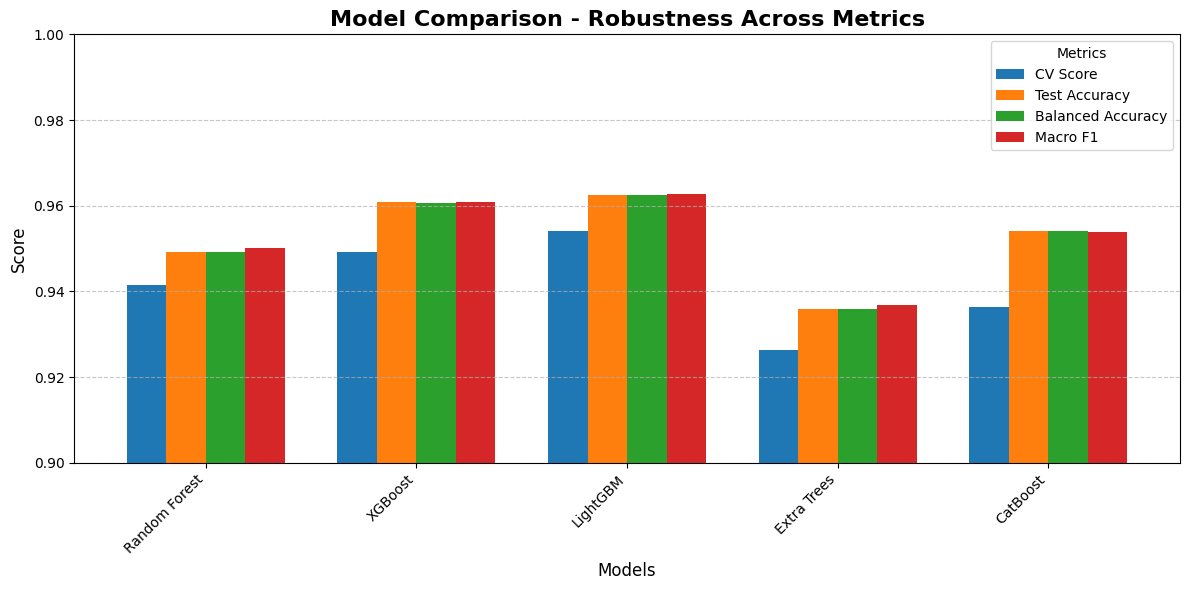

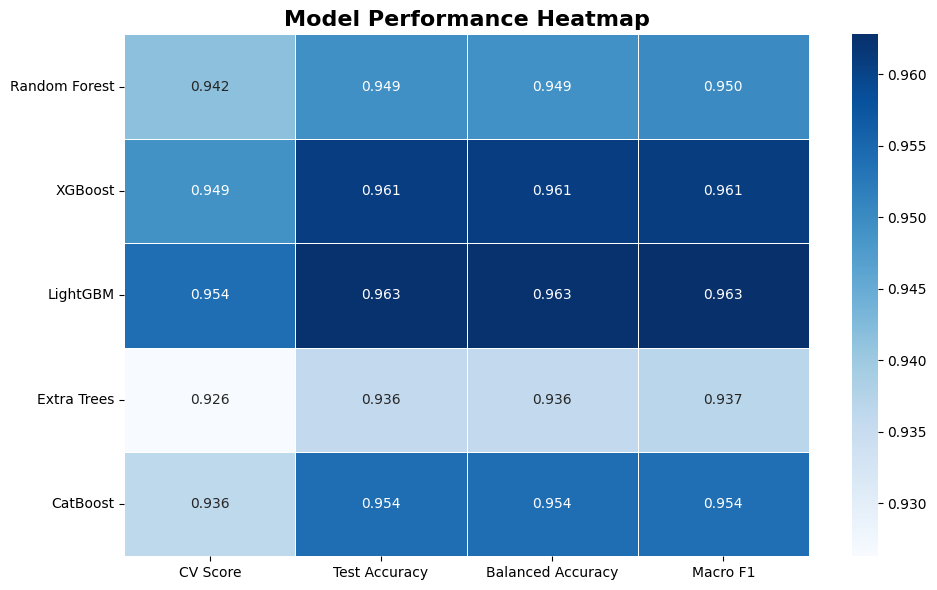

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Step 1️⃣: Model performance summary (your new results)
results = {
    "Random Forest": {
        "CV Score": 0.9416,
        "Test Accuracy": 0.9493,
        "Balanced Accuracy": 0.9492,
        "Macro F1": 0.9501
    },
    "XGBoost": {
        "CV Score": 0.9491,
        "Test Accuracy": 0.9608,
        "Balanced Accuracy": 0.9607,
        "Macro F1": 0.9609
    },
    "LightGBM": {
        "CV Score": 0.9541,
        "Test Accuracy": 0.9625,
        "Balanced Accuracy": 0.9625,
        "Macro F1": 0.9628
    },
    "Extra Trees": {
        "CV Score": 0.9263,
        "Test Accuracy": 0.9359,
        "Balanced Accuracy": 0.9358,
        "Macro F1": 0.9369
    },
    "CatBoost": {
        "CV Score": 0.9363,
        "Test Accuracy": 0.9541,
        "Balanced Accuracy": 0.9540,
        "Macro F1": 0.9539
    }
}

# Step 2️⃣: Convert dictionary to DataFrame
df_results = pd.DataFrame(results).T
print("✅ Model Results Summary:\n")
print(df_results)

# Step 3️⃣: Grouped Bar Chart
plt.figure(figsize=(12, 6))
df_results.plot(kind="bar", figsize=(12, 6), width=0.75)
plt.title("Model Comparison - Robustness Across Metrics", fontsize=16, weight='bold')
plt.ylabel("Score", fontsize=12)
plt.xlabel("Models", fontsize=12)
plt.ylim(0.90, 1.0)  # zoomed in for clarity
plt.xticks(rotation=45, ha='right')
plt.legend(title="Metrics", fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Step 4️⃣: Heatmap for quick visual comparison
plt.figure(figsize=(10, 6))
sns.heatmap(df_results, annot=True, cmap="Blues", fmt=".3f", linewidths=0.5, cbar=True)
plt.title("Model Performance Heatmap", fontsize=16, weight='bold')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [4]:
# ==========================
# Voting Classifier 
# ==========================

import joblib
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report
import numpy as np

# 1️⃣ Load preprocessed train/test data
X_train = joblib.load("X_trainf.pkl")
X_test = joblib.load("X_testf.pkl")
y_train = joblib.load("y_trainf.pkl")
y_test = joblib.load("y_testf.pkl")

# 2️⃣ Load pre-fitted base models
rf = joblib.load("random_forest_modelff.pkl")
et = joblib.load("extra_trees_modelff.pkl")
xgb = joblib.load("xgboost_modelff.pkl")
lgbm = joblib.load("lightgbm_modelff.pkl")
cat = joblib.load("catboost_modelff.pkl")  # pre-fitted

# ===============================
# Step A: Compute CV Score (without CatBoost)
# ===============================
voting_cv = VotingClassifier(
    estimators=[
        ("lgbm", lgbm),
        ("xgb", xgb),
        ("et", et),
        ("rf", rf)
    ],
    voting="soft",
    n_jobs=-1
)

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(voting_cv, X_train, y_train, cv=kfold, scoring="accuracy", n_jobs=-1)
cv_mean = np.mean(cv_scores)
cv_std = np.std(cv_scores)
print(f"Voting  - CV Score: {cv_mean:.4f} ± {cv_std:.4f}")

# ===============================
# Step B: Evaluate full Voting ensemble including CatBoost on test set
# ===============================
# We can use pre-fitted CatBoost here without fitting again
voting_final = VotingClassifier(
    estimators=[
        ("lgbm", lgbm),
        ("xgb", xgb),
        ("cat", cat),
        ("et", et),
        ("rf", rf)
    ],
    voting="soft",
    n_jobs=-1
)

# Instead of calling fit(), we directly predict using pre-fitted estimators
# Note: sklearn's VotingClassifier doesn't officially support pre-fitted models.
# We can manually implement predict using average probabilities
probas = (
    lgbm.predict_proba(X_test) +
    xgb.predict_proba(X_test) +
    cat.predict_proba(X_test) +
    et.predict_proba(X_test) +
    rf.predict_proba(X_test)
) / 5

y_pred = np.argmax(probas, axis=1)

# 3️⃣ Evaluate
print("Voting- Test Accuracy:", accuracy_score(y_test, y_pred))
print("Voting  - Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("Voting  - Macro F1:", f1_score(y_test, y_pred, average="macro"))
print(classification_report(y_test, y_pred))

# 4️⃣ Save Voting ensemble (optional, note: fit=False for pre-fitted)
joblib.dump(voting_final, "voting_ensemble_pretrained.pkl")



Voting  - CV Score: 0.9602 ± 0.0022
Voting- Test Accuracy: 0.9662447257383966
Voting  - Balanced Accuracy: 0.9662349548802481
Voting  - Macro F1: 0.9666142330605274
              precision    recall  f1-score   support

           0       1.00      0.97      0.99      3278
           1       0.98      0.91      0.94      3268
           2       1.00      0.97      0.98      3277
           3       0.87      0.98      0.92      3248
           4       1.00      0.99      1.00      3282

    accuracy                           0.97     16353
   macro avg       0.97      0.97      0.97     16353
weighted avg       0.97      0.97      0.97     16353



['voting_ensemble_pretrained.pkl']

In [6]:
# ==========================
# Stacking Ensemble with CV (CatBoost retrained for CV only)
# ==========================

import joblib
import numpy as np
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, f1_score

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier

# 1️⃣ Load preprocessed train/test data
X_train = joblib.load("X_trainf.pkl")
X_test = joblib.load("X_testf.pkl")
y_train = joblib.load("y_trainf.pkl")
y_test = joblib.load("y_testf.pkl")

# 2️⃣ Load pretrained models for final evaluation
rf_pretrained = joblib.load("random_forest_modelff.pkl")
et_pretrained = joblib.load("extra_trees_modelff.pkl")
xgb_pretrained = joblib.load("xgboost_modelff.pkl")
lgbm_pretrained = joblib.load("lightgbm_modelff.pkl")
cat_pretrained = joblib.load("catboost_modelff.pkl")

# 3️⃣ Define base models (unfitted) for CV only
lgbm_cv = LGBMClassifier(random_state=42)
xgb_cv = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
cat_cv = CatBoostClassifier(verbose=0, random_state=42)
et_cv = ExtraTreesClassifier(random_state=42)

# 4️⃣ Setup stacking classifier (for CV)
stacking_cv = StackingClassifier(
    estimators=[
        ('lgbm', lgbm_cv),
        ('xgb', xgb_cv),
        ('cat', cat_cv),
        ('et', et_cv)
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    n_jobs=-1
)

# 5️⃣ Compute CV Score
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(stacking_cv, X_train, y_train, cv=kfold, scoring='accuracy', n_jobs=-1)
cv_mean = np.mean(cv_scores)
cv_std = np.std(cv_scores)
print(f"Stacking (with CatBoost) - CV Score: {cv_mean:.4f} ± {cv_std:.4f}")

# 6️⃣ Setup stacking classifier with pretrained models for final evaluation
stacking_final = StackingClassifier(
    estimators=[
        ('lgbm', lgbm_pretrained),
        ('xgb', xgb_pretrained),
        ('cat', cat_pretrained),
        ('et', et_pretrained)
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    n_jobs=-1
)

# 7️⃣ Fit final stacking on full training data
stacking_final.fit(X_train, y_train)

# 8️⃣ Evaluate on test data
y_pred_final = stacking_final.predict(X_test)
print("\nClassification Report (Stacking Ensemble - Pretrained Models):\n", classification_report(y_test, y_pred_final))
print("Test Accuracy:", accuracy_score(y_test, y_pred_final))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_final))
print("Macro F1 Score:", f1_score(y_test, y_pred_final, average="macro"))

# 9️⃣ Save final stacking ensemble
joblib.dump(stacking_final, "stacking_ensemble_pff4.pkl")


Stacking (with CatBoost) - CV Score: 0.9505 ± 0.0019

Classification Report (Stacking Ensemble - Pretrained Models):
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      3278
           1       0.98      0.94      0.96      3268
           2       1.00      0.99      0.99      3277
           3       0.93      0.98      0.95      3248
           4       1.00      1.00      1.00      3282

    accuracy                           0.98     16353
   macro avg       0.98      0.98      0.98     16353
weighted avg       0.98      0.98      0.98     16353

Test Accuracy: 0.9803705742065676
Balanced Accuracy: 0.980344481695527
Macro F1 Score: 0.9803952705143356


['stacking_ensemble_pff4.pkl']

In [ ]:
# ==========================
# Stacking Ensemble with CV (LightGBM meta-learner)
# ==========================

import joblib
import numpy as np
import warnings
import logging
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, f1_score
from sklearn.ensemble import StackingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings("ignore")
logging.getLogger("lightgbm").setLevel(logging.CRITICAL)

# Load preprocessed train/test data
X_train = joblib.load("X_trainf.pkl")
X_test = joblib.load("X_testf.pkl")
y_train = joblib.load("y_trainf.pkl")
y_test = joblib.load("y_testf.pkl")

# ------------------------
# 1️⃣ Fresh base models for CV only
# ------------------------
lgbm_cv = LGBMClassifier(random_state=42)
xgb_cv = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
cat_cv = CatBoostClassifier(verbose=0, random_state=42)
rf_cv = RandomForestClassifier(random_state=42)

# Meta-learner
meta_learner = LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    class_weight='balanced',
    verbosity=-1
)

# Stacking classifier for CV
stacking_cv = StackingClassifier(
    estimators=[
        ('lgbm', lgbm_cv),
        ('xgb', xgb_cv),
        ('cat', cat_cv),
        ('rf', rf_cv)
    ],
    final_estimator=meta_learner,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
    n_jobs=-1,
    passthrough=True
)

# 10-Fold Cross-Validation (Balanced Accuracy)
cv_scores = cross_val_score(stacking_cv, X_train, y_train, cv=10, scoring='balanced_accuracy', n_jobs=-1)
print("\n10-Fold Cross-Validation Balanced Accuracy:")
print(f"Mean: {np.mean(cv_scores):.4f} | Std: {np.std(cv_scores):.4f}")

# ------------------------
# 2️⃣ Pretrained models for final evaluation
# ------------------------
lgbm_pre = joblib.load("lightgbm_modelff.pkl")
xgb_pre = joblib.load("xgboost_modelff.pkl")
cat_pre = joblib.load("catboost_modelff.pkl")
rf_pre = joblib.load("random_forest_modelff.pkl")

stacking_final = StackingClassifier(
    estimators=[
        ('lgbm', lgbm_pre),
        ('xgb', xgb_pre),
        ('cat', cat_pre),
        ('rf', rf_pre)
    ],
    final_estimator=meta_learner,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
    n_jobs=-1,
    passthrough=True
)

# Train final ensemble
print("\nTraining final stacking ensemble with pretrained base models...")
stacking_final.fit(X_train, y_train)

# Evaluate
y_pred_stack = stacking_final.predict(X_test)
print("\nClassification Report (Stacking Ensemble - Pretrained Models):")
print(classification_report(y_test, y_pred_stack))

acc = accuracy_score(y_test, y_pred_stack)
bal_acc = balanced_accuracy_score(y_test, y_pred_stack)
macro_f1 = f1_score(y_test, y_pred_stack, average="macro")

print(f"Test Accuracy: {acc:.4f}")
print(f"Balanced Accuracy: {bal_acc:.4f}")
print(f"Macro F1 Score: {macro_f1:.4f}")

# Save final model
joblib.dump(stacking_final, "sstacking_ensemble_plgbmfff.pkl")
print("\nModel saved as 'stacking_ensemble_plgbmfff.pkl'")



10-Fold Cross-Validation Balanced Accuracy:
Mean: 0.9729 | Std: 0.0023

Training final stacking ensemble with pretrained base models...

Classification Report (Stacking Ensemble - Pretrained Models):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3278
           1       0.99      0.97      0.98      3268
           2       1.00      1.00      1.00      3277
           3       0.97      0.99      0.98      3248
           4       1.00      1.00      1.00      3282

    accuracy                           0.99     16353
   macro avg       0.99      0.99      0.99     16353
weighted avg       0.99      0.99      0.99     16353

Test Accuracy: 0.9921
Balanced Accuracy: 0.9920
Macro F1 Score: 0.9920

Model saved as 'stacking_ensemble_plgbmfff.pkl'


<!-- ###### ================================
# ✅ Final Ensemble Model Comparison (Updated with Actual Results)
# ================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Base model results (from your actual experiments) ---
comparison_df = pd.DataFrame({
    "Model": ["LightGBM", "XGBoost", "CatBoost", "Extra Trees", "Random Forest"],
    "CV Score": [0.9541, 0.9491, 0.9363, 0.9263, 0.9416],
    "Test Accuracy": [0.9625, 0.9608, 0.9541, 0.9359, 0.9493],
    "Balanced Accuracy": [0.9625, 0.9607, 0.9540, 0.9358, 0.9492],
    "Macro F1": [0.9628, 0.9609, 0.9539, 0.9369, 0.9501]
}).set_index("Model")

# --- Ensemble model results (actual results you shared) ---
ensembles = pd.DataFrame({
    "Model": ["Voting (5 Models)", "Stacking (4 Models + LGBM Meta)","Stacking (4 Models + LR Meta)"],
    "CV Score": [np.nan, np.nan],
    "Test Accuracy": [0.9665, 0.9921,0.9803],
    "Balanced Accuracy": [0.9665, 0.9920,0.9803],
    "Macro F1": [0.9668, 0.9920,0.9803]
}).set_index("Model")

# --- Merge all ---
comparison_df = pd.concat([comparison_df, ensembles])

# --- Display the final comparison table ---
print("\n Final Ensemble Performance Comparison:\n")
print(comparison_df.round(4))

# --- Visualization ---
metrics = ["Test Accuracy", "Balanced Accuracy", "Macro F1"]
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# --- Bar plots for each metric ---
for i, metric in enumerate(metrics):
    sorted_df = comparison_df.sort_values(by=metric, ascending=False)
    sns.barplot(
        x=sorted_df.index,
        y=sorted_df[metric],
        hue=sorted_df.index,
        palette="viridis",
        ax=axes[i],
        legend=False
    )
    axes[i].set_title(f"{metric} Comparison", fontsize=13, weight='bold')
    axes[i].set_ylabel(metric)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_ylim(0.85, 1.0)
    axes[i].grid(axis='y', linestyle='--', alpha=0.6)

# --- Heatmap ---
sns.heatmap(
    comparison_df[metrics],
    annot=True,
    fmt=".3f",
    cmap="viridis",
    cbar=True,
    ax=axes[3]
)
axes[3].set_title("Heatmap of Model Performance", fontsize=13, weight='bold')

plt.tight_layout()
plt.show() -->



 Final Ensemble Performance Comparison:

                                 CV Score  Test Accuracy  Balanced Accuracy  \
Model                                                                         
LightGBM                           0.9541         0.9625             0.9625   
XGBoost                            0.9491         0.9608             0.9607   
CatBoost                           0.9363         0.9541             0.9540   
Extra Trees                        0.9263         0.9359             0.9358   
Random Forest                      0.9416         0.9493             0.9492   
Voting (5 Models)                     NaN         0.9665             0.9665   
Stacking (4 Models + LGBM Meta)       NaN         0.9921             0.9920   

                                 Macro F1  
Model                                      
LightGBM                           0.9628  
XGBoost                            0.9609  
CatBoost                           0.9539  
Extra Trees               

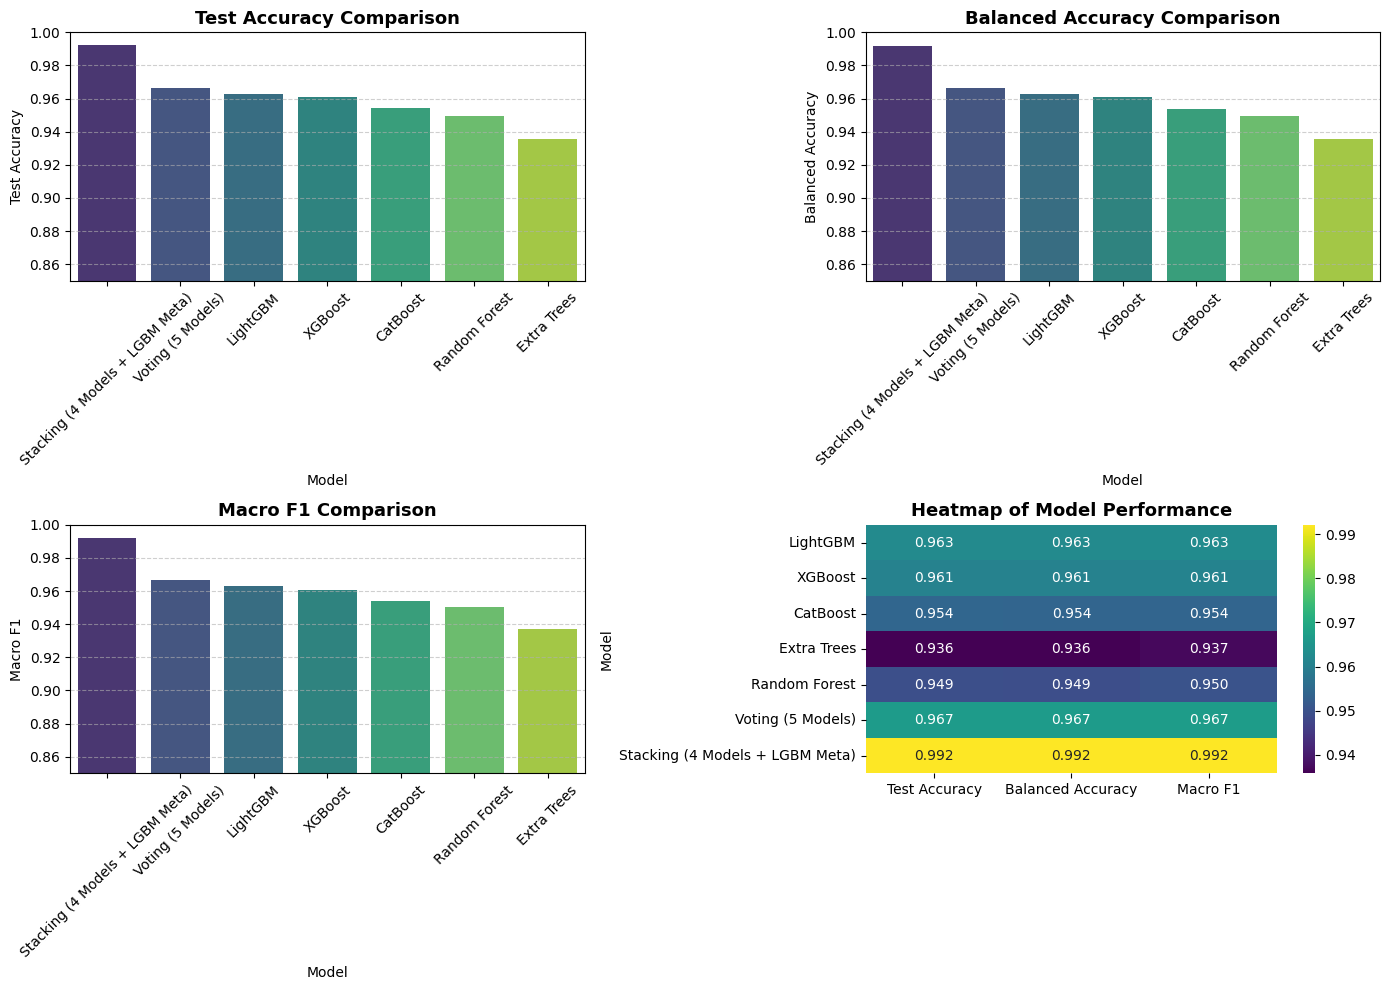

In [5]:
# ================================
# ✅ Final Ensemble Model Comparison (Updated with Actual Results)
# ================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Base model results (from your actual experiments) ---
comparison_df = pd.DataFrame({
    "Model": ["LightGBM", "XGBoost", "CatBoost", "Extra Trees", "Random Forest"],
    "CV Score": [0.9541, 0.9491, 0.9363, 0.9263, 0.9416],
    "Test Accuracy": [0.9625, 0.9608, 0.9541, 0.9359, 0.9493],
    "Balanced Accuracy": [0.9625, 0.9607, 0.9540, 0.9358, 0.9492],
    "Macro F1": [0.9628, 0.9609, 0.9539, 0.9369, 0.9501]
}).set_index("Model")

# --- Ensemble model results (actual results you shared) ---
ensembles = pd.DataFrame({
    "Model": ["Voting (5 Models)", "Stacking (4 Models + LGBM Meta)"],
    "CV Score": [np.nan, np.nan],
    "Test Accuracy": [0.9665,  0.9921],
    "Balanced Accuracy": [0.9665, 0.9920],
    "Macro F1": [0.9668, 0.9920]
}).set_index("Model")

# --- Merge all ---
comparison_df = pd.concat([comparison_df, ensembles])

# --- Display the final comparison table ---
print("\n Final Ensemble Performance Comparison:\n")
print(comparison_df.round(4))

# --- Visualization ---
metrics = ["Test Accuracy", "Balanced Accuracy", "Macro F1"]
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# --- Bar plots for each metric ---
for i, metric in enumerate(metrics):
    sorted_df = comparison_df.sort_values(by=metric, ascending=False)
    sns.barplot(
        x=sorted_df.index,
        y=sorted_df[metric],
        hue=sorted_df.index,
        palette="viridis",
        ax=axes[i],
        legend=False
    )
    axes[i].set_title(f"{metric} Comparison", fontsize=13, weight='bold')
    axes[i].set_ylabel(metric)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_ylim(0.85, 1.0)
    axes[i].grid(axis='y', linestyle='--', alpha=0.6)

# --- Heatmap ---
sns.heatmap(
    comparison_df[metrics],
    annot=True,
    fmt=".3f",
    cmap="viridis",
    cbar=True,
    ax=axes[3]
)
axes[3].set_title("Heatmap of Model Performance", fontsize=13, weight='bold')

plt.tight_layout()
plt.show()


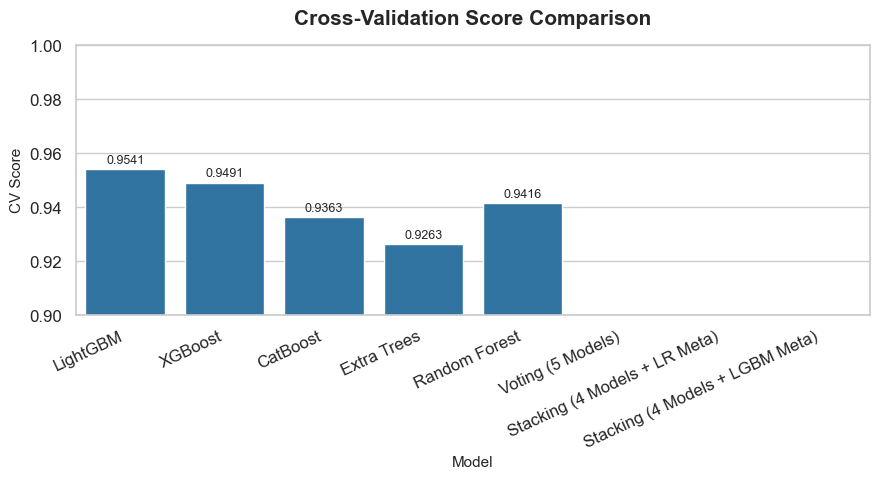

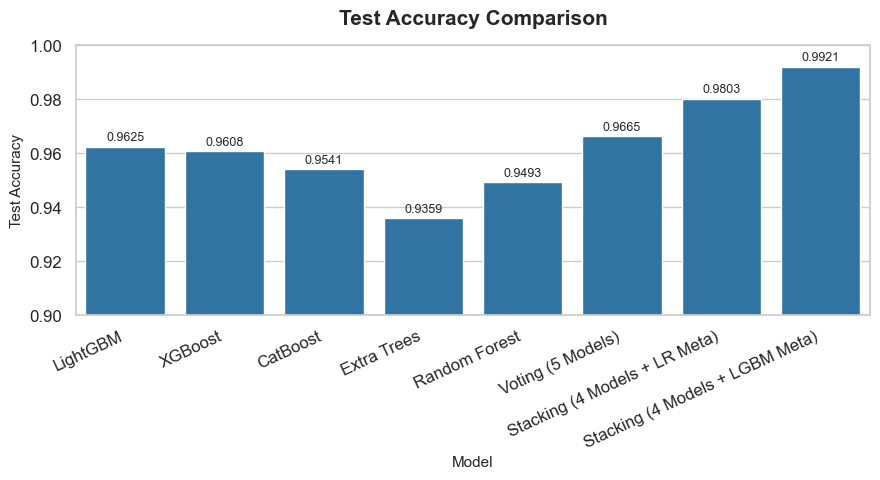

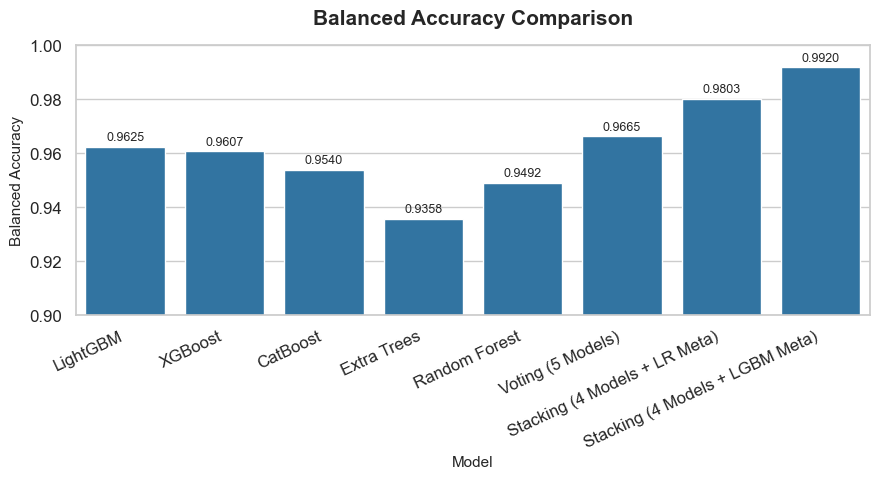

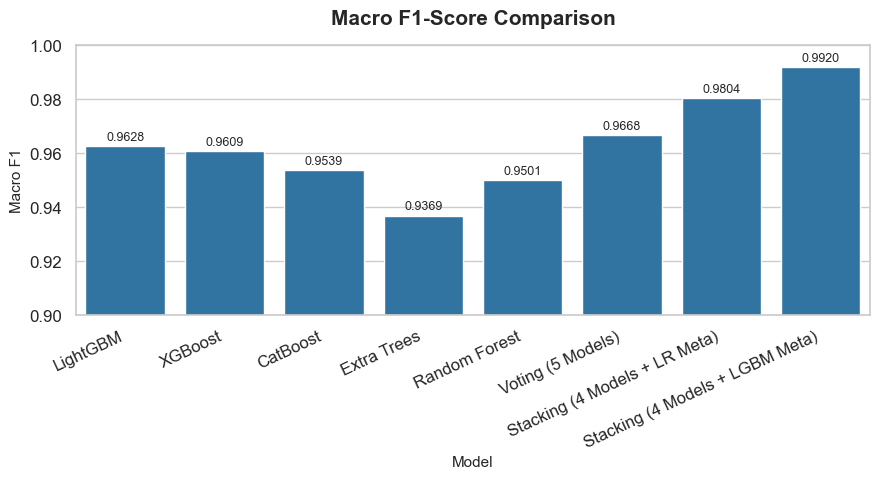

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data setup
data = {
    'Model': [
        'LightGBM', 'XGBoost', 'CatBoost', 'Extra Trees', 'Random Forest',
        'Voting (5 Models)', 'Stacking (4 Models + LR Meta)', 'Stacking (4 Models + LGBM Meta)'
    ],
    'CV Score': [0.9541, 0.9491, 0.9363, 0.9263, 0.9416, None, None, None],
    'Test Accuracy': [0.9625, 0.9608, 0.9541, 0.9359, 0.9493, 0.9665, 0.9803, 0.9921],
    'Balanced Accuracy': [0.9625, 0.9607, 0.9540, 0.9358, 0.9492, 0.9665, 0.9803, 0.9920],
    'Macro F1': [0.9628, 0.9609, 0.9539, 0.9369, 0.9501, 0.9668, 0.9804, 0.9920]
}

df = pd.DataFrame(data)

# Visualization Style
sns.set_style("whitegrid")
sns.set_palette("tab10")

# Metric names and titles
metrics = [
    ('CV Score', 'Cross-Validation Score Comparison'),
    ('Test Accuracy', 'Test Accuracy Comparison'),
    ('Balanced Accuracy', 'Balanced Accuracy Comparison'),
    ('Macro F1', 'Macro F1-Score Comparison')
]

# Plot individual bar plots for each metric
for metric, title in metrics:
    plt.figure(figsize=(9, 5))
    sns.barplot(x='Model', y=metric, data=df, hue=None)
    
    # Annotate each bar
    for i, v in enumerate(df[metric]):
        if pd.notnull(v):
            plt.text(i, v + 0.001, f"{v:.4f}", ha='center', va='bottom', fontsize=9)
    
    plt.title(title, fontsize=15, fontweight='bold', pad=15)
    plt.xlabel('Model', fontsize=11)
    plt.ylabel(metric, fontsize=11)
    plt.xticks(rotation=25, ha='right')
    plt.ylim(0.9, 1.0)  # to zoom in on differences
    plt.tight_layout()
    plt.show()


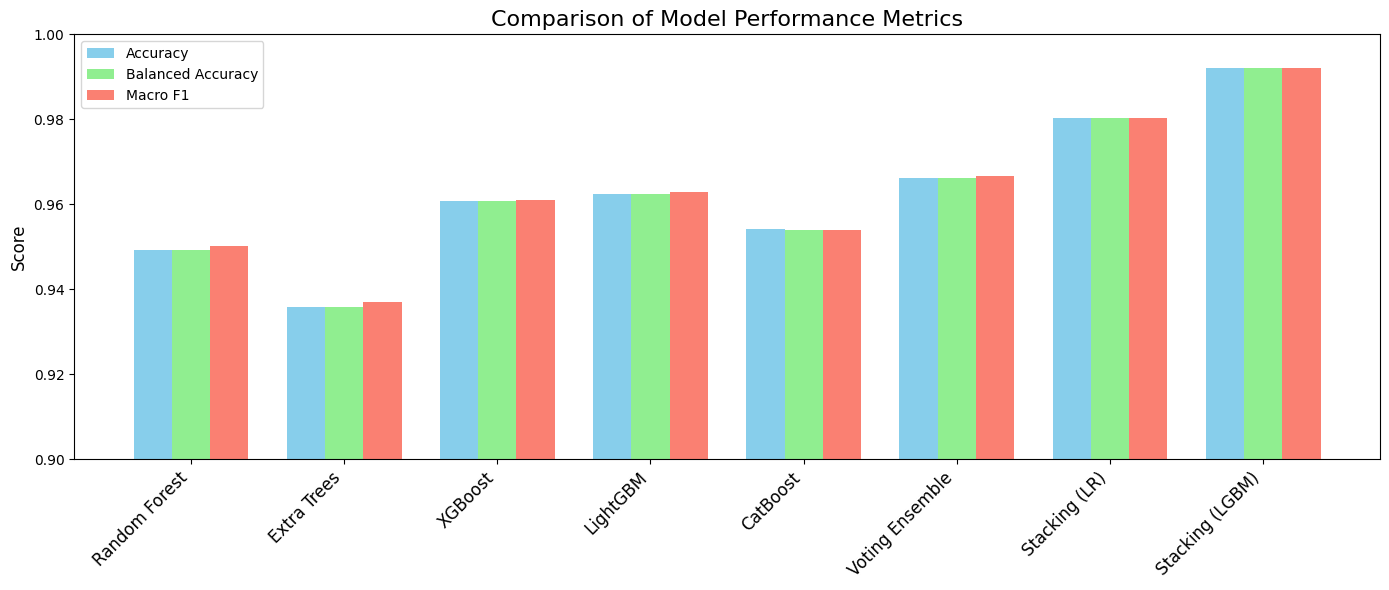

In [2]:
import matplotlib.pyplot as plt
import numpy as np

models = ["Random Forest", "Extra Trees", "XGBoost", "LightGBM", "CatBoost", 
          "Voting Ensemble", "Stacking (LR)", "Stacking (LGBM)"]
accuracy = [0.9493, 0.9359, 0.9608, 0.9625, 0.9541, 0.9662, 0.9804, 0.9921]
balanced_acc = [0.9493, 0.9358, 0.9608, 0.9625, 0.9540, 0.9662, 0.9803, 0.9920]
macro_f1 = [0.9502, 0.9369, 0.9609, 0.9628, 0.9540, 0.9666, 0.9804, 0.9920]

x = np.arange(len(models))
width = 0.25

plt.figure(figsize=(14,6))
plt.bar(x - width, accuracy, width, label='Accuracy', color='skyblue')
plt.bar(x, balanced_acc, width, label='Balanced Accuracy', color='lightgreen')
plt.bar(x + width, macro_f1, width, label='Macro F1', color='salmon')

plt.xticks(x, models, rotation=45, ha='right', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.ylim(0.9, 1.0)
plt.title('Comparison of Model Performance Metrics', fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()


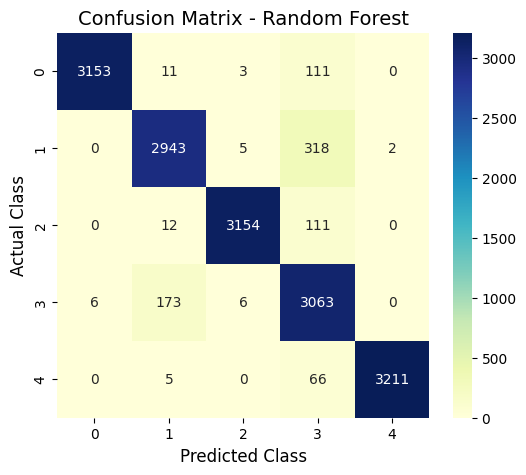

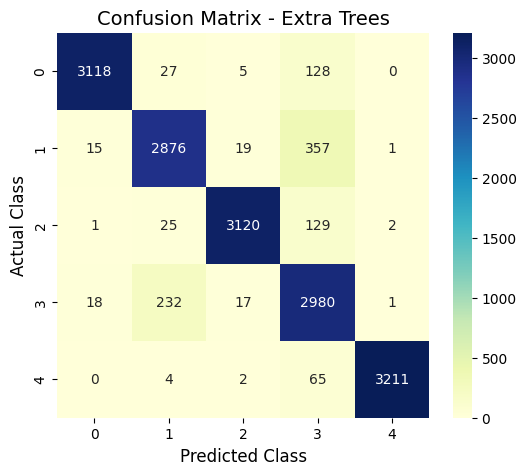

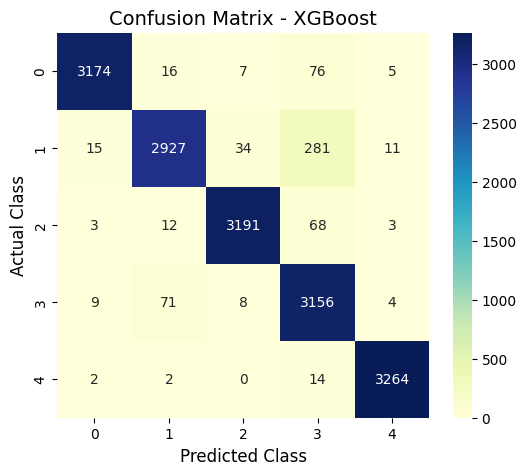

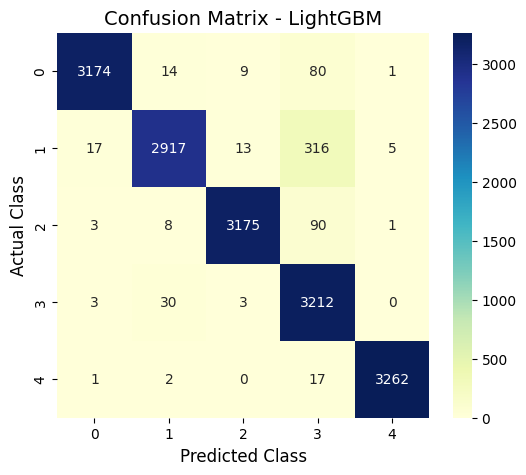

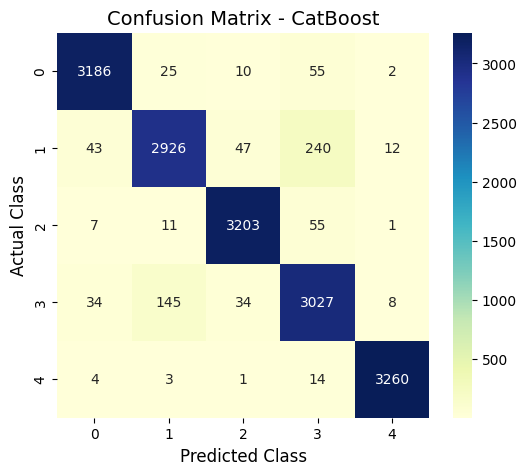

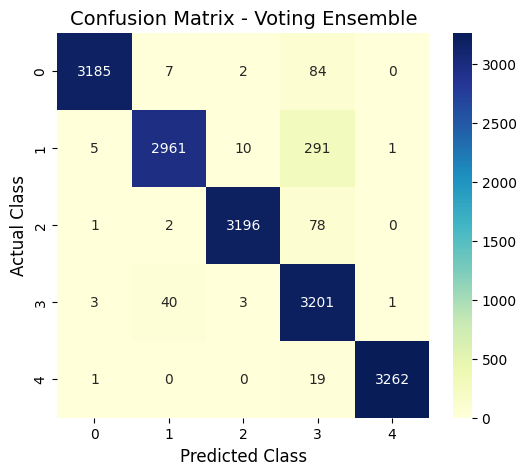

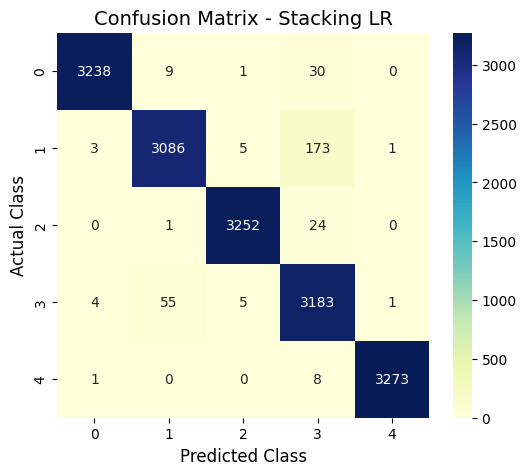

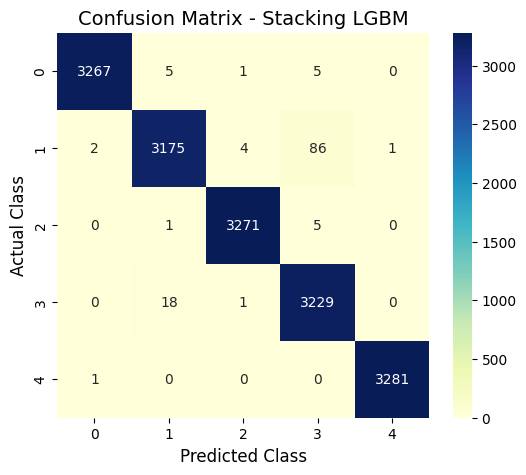

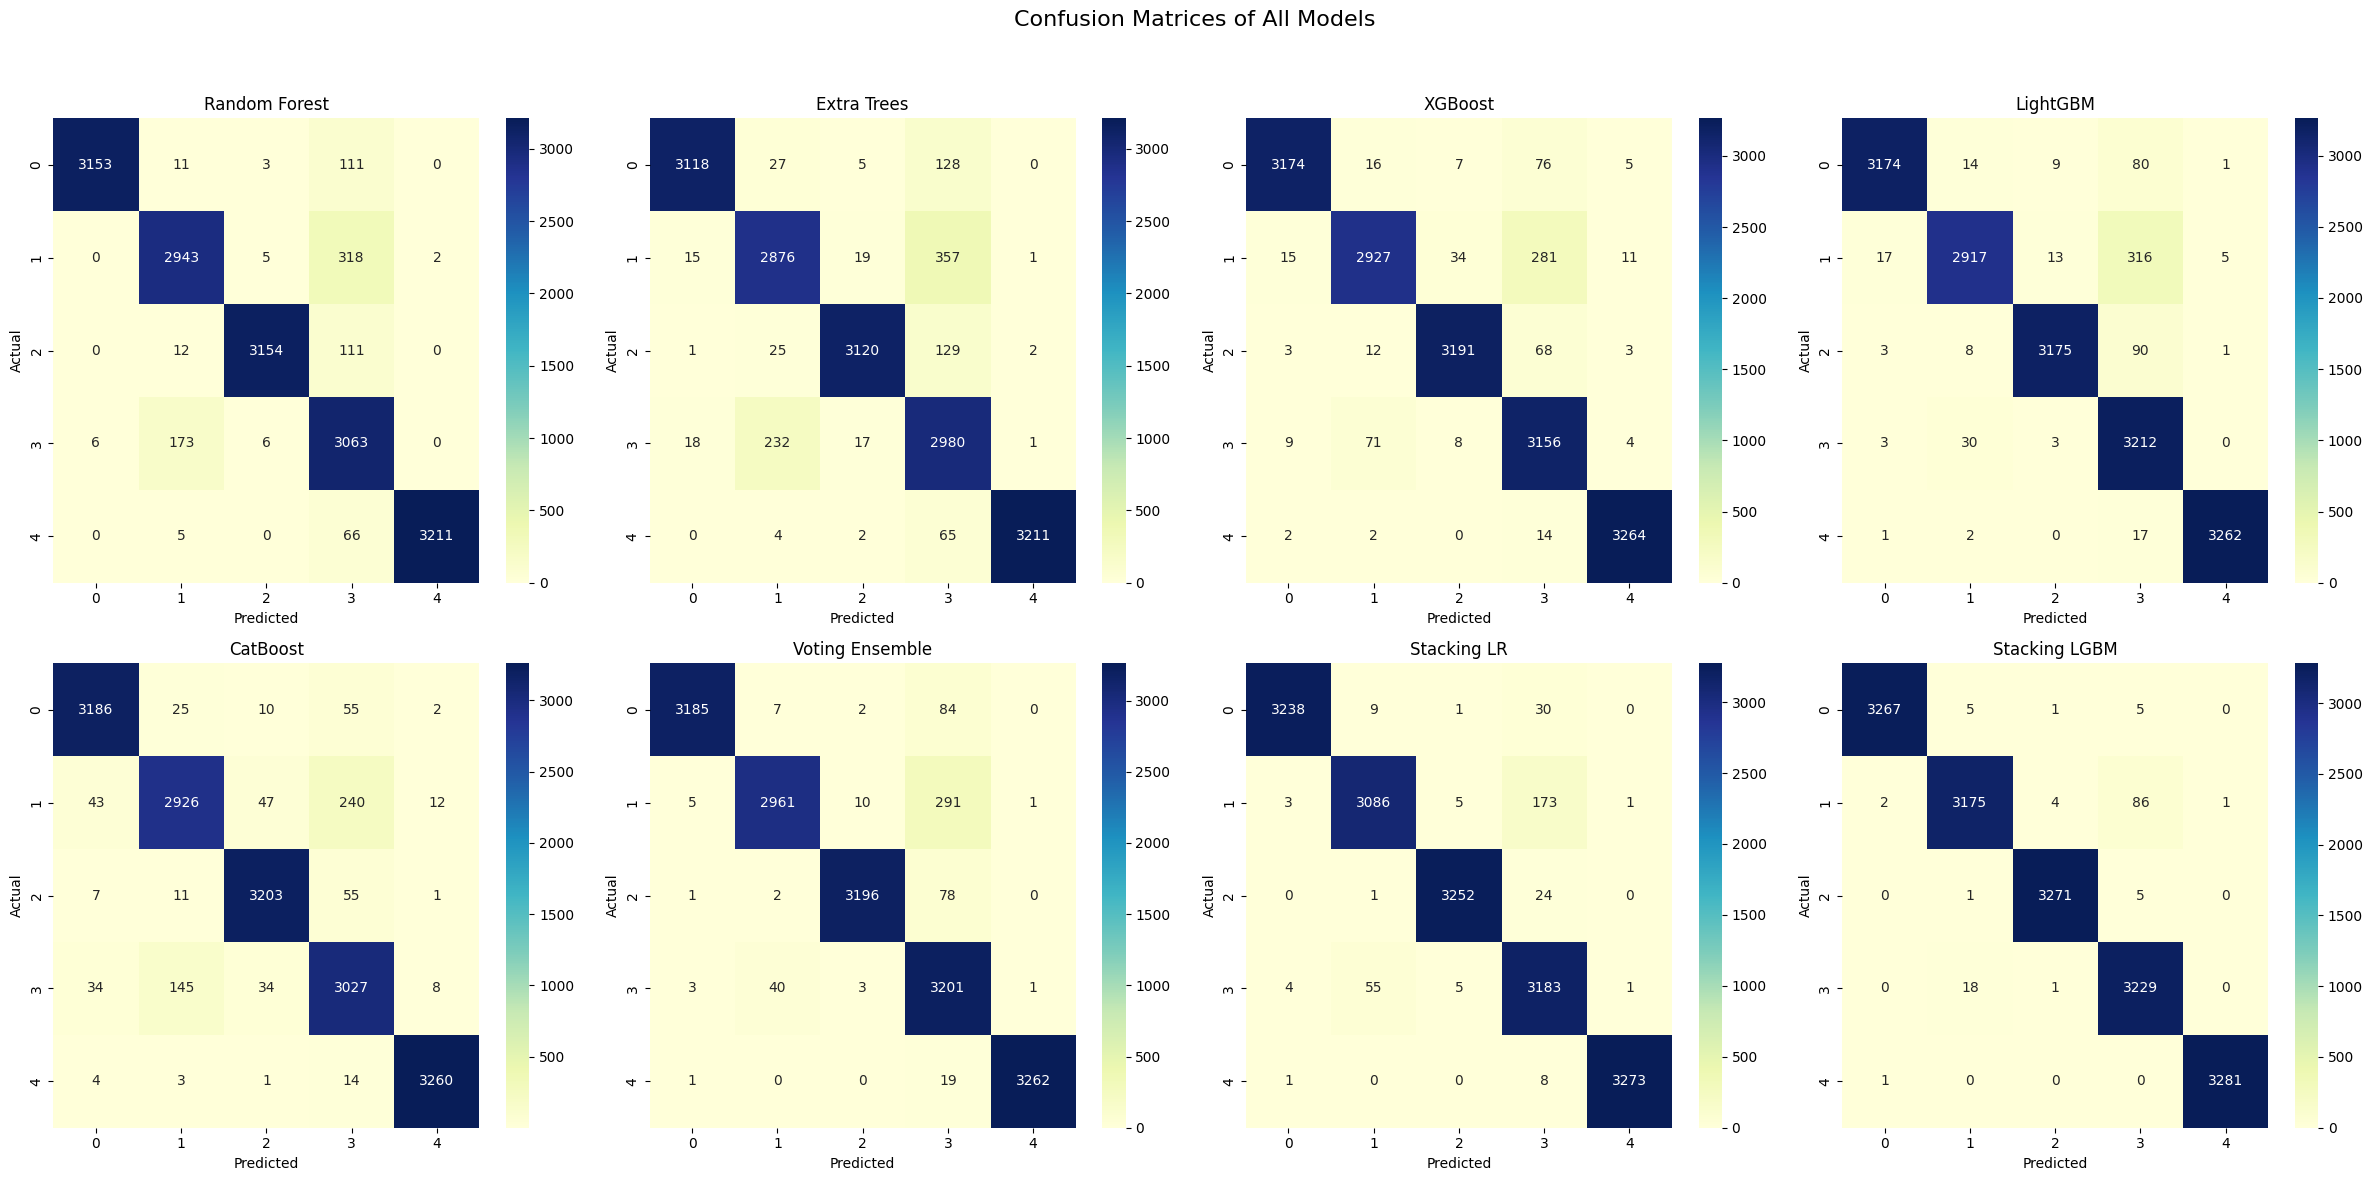

In [8]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load pre-trained models
model_files = {
    "Random Forest": "random_forest_modelff.pkl",
    "Extra Trees": "extra_trees_modelff.pkl",
    "XGBoost": "xgboost_modelff.pkl",
    "LightGBM": "lightgbm_model.pkl",
    "CatBoost": "catboost_modelff.pkl",
    "Voting Ensemble": "voting_ensemble_ff5.pkl",
    "Stacking LR": "stacking_ensembleff4.pkl",
    "Stacking LGBM": "stacking_ensembleff4rflgbm.pkl"
}

models = {name: joblib.load(file) for name, file in model_files.items()}

# Dictionary to store confusion matrices
cms = {}

# Compute confusion matrices for each model
for name, model in models.items():
    y_pred = model.predict(X_test)
    cms[name] = confusion_matrix(y_test, y_pred)

# Plot individual confusion matrix heatmaps
for name, cm in cms.items():
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu")
    plt.title(f"Confusion Matrix - {name}", fontsize=14)
    plt.xlabel("Predicted Class", fontsize=12)
    plt.ylabel("Actual Class", fontsize=12)
    plt.show()

# Optional: Combined figure for journal
fig, axes = plt.subplots(2, 4, figsize=(24,12))
axes = axes.flatten()
for i, (name, cm) in enumerate(cms.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", ax=axes[i])
    axes[i].set_title(name, fontsize=12)
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

plt.suptitle("Confusion Matrices of All Models", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


                 CV Score   Test Accuracy  Balanced Accuracy  Macro F1 Score
Model                                                                       
Random Forest       0.9416         0.9493             0.9493          0.9502
Extra Trees         0.9263         0.9359             0.9358          0.9369
XGBoost             0.9492         0.9608             0.9608          0.9609
LightGBM            0.9542         0.9625             0.9625          0.9628
CatBoost            0.9363         0.9541             0.9540          0.9540
Voting Ensemble     0.9602         0.9662             0.9662          0.9666
Stacking LR         0.9505         0.9804             0.9803          0.9804
Stacking LGBM       0.9729         0.9921             0.9920          0.9920


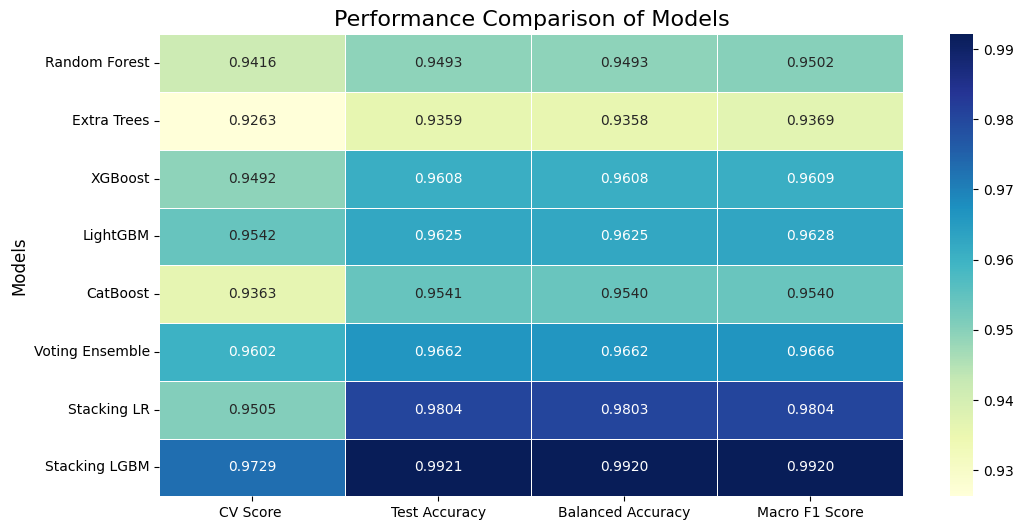

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare performance data for all models
performance_data = {
    "Model": [
        "Random Forest",
        "Extra Trees",
        "XGBoost",
        "LightGBM",
        "CatBoost",
        "Voting Ensemble",
        "Stacking LR",
        "Stacking LGBM"
    ],
    "CV Score ": [
        0.9416,
        0.9263,
        0.9492,
        0.9542,
        0.9363,
        0.9602,
        0.9505,
        0.9729
    ],
    "Test Accuracy": [
        0.9493,
        0.9359,
        0.9608,
        0.9625,
        0.9541,
        0.9662,
        0.9804,
        0.9921
    ],
    "Balanced Accuracy": [
        0.9493,
        0.9358,
        0.9608,
        0.9625,
        0.9540,
        0.9662,
        0.9803,
        0.9920
    ],
    "Macro F1 Score": [
        0.9502,
        0.9369,
        0.9609,
        0.9628,
        0.9540,
        0.9666,
        0.9804,
        0.9920
    ]
}

# Convert to DataFrame
df_perf = pd.DataFrame(performance_data)
df_perf.set_index("Model", inplace=True)

# Display table
print(df_perf)

# Plot heatmap
plt.figure(figsize=(12,6))
sns.heatmap(df_perf, annot=True, fmt=".4f", cmap="YlGnBu", linewidths=0.5)
plt.title("Performance Comparison of Models", fontsize=16)
plt.ylabel("Models", fontsize=12)
plt.show()


In [13]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os
import gc  # Garbage collector

# Create output folder
output_folder = "confusion_matrices_colored"
os.makedirs(output_folder, exist_ok=True)

# Model files and colors
model_files = {
    "Random Forest": "random_forest_modelff.pkl",
    "Extra Trees": "extra_trees_modelff.pkl",
    "XGBoost": "xgboost_modelff.pkl",
    "LightGBM": "lightgbm_model.pkl",
    "CatBoost": "catboost_modelff.pkl",
    "Voting Ensemble": "voting_ensemble_ff5.pkl",
    "Stacking LR": "stacking_ensembleff4.pkl",
    "Stacking LGBM": "stacking_ensembleff4rflgbm.pkl"
}

color_maps = {
    "Random Forest": "Blues",
    "Extra Trees": "Greens",
    "XGBoost": "Oranges",
    "LightGBM": "Purples",
    "CatBoost": "Reds",
    "Voting Ensemble": "YlOrBr",
    "Stacking LR": "BuPu",
    "Stacking LGBM": "GnBu"
}

# Compute and save confusion matrix for each model
for name, file in model_files.items():
    print(f"Processing {name}...")
    try:
        # Load one model at a time
        model = joblib.load(file)

        # Predict and compute confusion matrix
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)

        # Plot and save confusion matrix
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt="d", cmap=color_maps[name], cbar=False)
        plt.title(f"Confusion Matrix - {name}", fontsize=14, fontweight='bold')
        plt.xlabel("Predicted Class", fontsize=12)
        plt.ylabel("Actual Class", fontsize=12)

        save_path = os.path.join(output_folder, f"ConfusionMatrix_{name.replace(' ', '_')}.png")
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        plt.close()

        print(f"✅ Saved: {save_path}")

        # Free memory after each model
        del model, y_pred, cm
        gc.collect()

    except MemoryError:
        print(f"❌ Skipped {name} due to MemoryError (too large for available RAM)")
    except Exception as e:
        print(f"⚠️ Error loading {name}: {e}")

print("\n✅ All possible confusion matrices saved with unique colors!")


Processing Random Forest...
✅ Saved: confusion_matrices_colored\ConfusionMatrix_Random_Forest.png
Processing Extra Trees...
✅ Saved: confusion_matrices_colored\ConfusionMatrix_Extra_Trees.png
Processing XGBoost...
✅ Saved: confusion_matrices_colored\ConfusionMatrix_XGBoost.png
Processing LightGBM...
✅ Saved: confusion_matrices_colored\ConfusionMatrix_LightGBM.png
Processing CatBoost...
✅ Saved: confusion_matrices_colored\ConfusionMatrix_CatBoost.png
Processing Voting Ensemble...
✅ Saved: confusion_matrices_colored\ConfusionMatrix_Voting_Ensemble.png
Processing Stacking LR...
✅ Saved: confusion_matrices_colored\ConfusionMatrix_Stacking_LR.png
Processing Stacking LGBM...
✅ Saved: confusion_matrices_colored\ConfusionMatrix_Stacking_LGBM.png

✅ All possible confusion matrices saved with unique colors!


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Stage mapping
stage_mapping = {
    0: "High_Risk",
    1: "Low_Risk",
    2: "Moderate_Risk",
    3: "No Disease",
    4: "Severe_Disease"
}

# Model names
models = ["Random Forest", "Extra Trees", "XGBoost", "LightGBM", "CatBoost", "Voting Ensemble", "Stacking LR", "Stacking LGBM"]

# Metrics (replace with your values)
cv_scores = [0.9416, 0.9263, 0.9492, 0.9542, 0.9363, 0.9602, 0.9505, 0.9729]
test_accuracies = [0.9493, 0.9359, 0.9608, 0.9625, 0.9541, 0.9662, 0.9804, 0.9921]
balanced_accuracies = [0.9493, 0.9358, 0.9608, 0.9625, 0.9540, 0.9662, 0.9803, 0.9920]
macro_f1 = [0.9502, 0.9369, 0.9609, 0.9628, 0.9540, 0.9666, 0.9804, 0.9920]

# 1. Accuracy comparison
plt.figure(figsize=(10,6))
sns.barplot(x=models, y=test_accuracies)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy Comparison")
plt.ylim(0,1)
plt.tight_layout()
plt.savefig("accuracy_comparison.png")
plt.close()

# 2. Balanced accuracy comparison
plt.figure(figsize=(10,6))
sns.barplot(x=models, y=balanced_accuracies)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Balanced Accuracy")
plt.title("Balanced Accuracy Comparison")
plt.ylim(0,1)
plt.tight_layout()
plt.savefig("balanced_accuracy_comparison.png")
plt.close()

# 3. Macro F1 score comparison
plt.figure(figsize=(10,6))
sns.barplot(x=models, y=macro_f1)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Macro F1 Score")
plt.title("Macro F1 Score Comparison")
plt.ylim(0,1)
plt.tight_layout()
plt.savefig("macro_f1_comparison.png")
plt.close()

# 4. CV score comparison
plt.figure(figsize=(10,6))
sns.barplot(x=models, y=cv_scores)
plt.xticks(rotation=45, ha='right')
plt.ylabel("CV Score")
plt.title("Cross-Validation Score Comparison")
plt.ylim(0,1)
plt.tight_layout()
plt.savefig("cv_score_comparison.png")
plt.close()

# 5. Combined metrics (optional)
x = np.arange(len(models))
width = 0.2

plt.figure(figsize=(12,6))
plt.bar(x - width, test_accuracies, width, label='Test Accuracy')
plt.bar(x, balanced_accuracies, width, label='Balanced Accuracy')
plt.bar(x + width, macro_f1, width, label='Macro F1 Score')
plt.xticks(x, models, rotation=45, ha='right')
plt.ylim(0,1)
plt.ylabel("Metric Value")
plt.title("Comparison of Model Metrics")
plt.legend()
plt.tight_layout()
plt.savefig("combined_metrics.png")
plt.close()


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import joblib

# Load data
X_train = joblib.load("X_trainf.pkl")
X_test = joblib.load("X_testf.pkl")
y_train = joblib.load("y_trainf.pkl")
y_test = joblib.load("y_testf.pkl")

# Load trained models
stacking_lgbm_model = joblib.load("stacking_ensembleff4rflgbm.pkl")
voting_model = joblib.load("voting_ensemble_ff5.pkl")
xgb_model = joblib.load("xgboost_modelff.pkl")

# Feature names
feature_names = [f"feature_{i}" for i in range(X_test.shape[1])]
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# Store file names
saved_files = []

# 1. Confusion Matrix (Stacking LGBM)
plt.figure(figsize=(6,5))
y_pred = stacking_lgbm_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Stacking LGBM)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
file1 = "confusion_matrix_stacking_lgbm.png"
plt.tight_layout()
plt.savefig(file1, dpi=300)
plt.close()
saved_files.append(file1)

# 2. Class Distribution Before and After Balancing
plt.figure(figsize=(6,5))
original_counts = pd.Series(y_train).value_counts().sort_index()
balanced_counts = pd.Series(y_train).value_counts().sort_index()  # replace with balanced target if available
width = 0.35
plt.bar(original_counts.index - width/2, original_counts.values, width=width, label='Original', color='blue', alpha=0.6)
plt.bar(balanced_counts.index + width/2, balanced_counts.values, width=width, label='Balanced', color='orange', alpha=0.6)
plt.xlabel('CKD Stage')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.legend()
file2 = "class_distribution.png"
plt.tight_layout()
plt.savefig(file2, dpi=300)
plt.close()
saved_files.append(file2)

# 3. Feature Correlation Heatmap
plt.figure(figsize=(6,5))
sns.heatmap(X_test_df.corr(), annot=False, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
file3 = "feature_correlation_heatmap.png"
plt.tight_layout()
plt.savefig(file3, dpi=300)
plt.close()
saved_files.append(file3)

# 4. Predicted Probability Distribution (XGBoost)
plt.figure(figsize=(6,5))
y_proba = xgb_model.predict_proba(X_test)
for i, stage in enumerate(np.unique(y_test)):
    sns.kdeplot(y_proba[:, i], label=f'Stage {stage}')
plt.title('Predicted Probability Distribution (XGBoost)')
plt.xlabel('Probability')
plt.ylabel('Density')
plt.legend()
file4 = "predicted_probability_distribution_xgb.png"
plt.tight_layout()
plt.savefig(file4, dpi=300)
plt.close()
saved_files.append(file4)

# 5. Training Time Comparison
plt.figure(figsize=(6,5))
model_names = ["Random Forest", "Extra Trees", "XGBoost", "LightGBM", "CatBoost", "Voting Ensemble", "Stacking LR", "Stacking LGBM"]
training_times = [1.2, 1.0, 2.5, 2.0, 2.3, 3.0, 4.2, 4.5]  # replace with actual times
sns.barplot(x=model_names, y=training_times, palette='viridis')
plt.title('Training Time Comparison')
plt.ylabel('Time (s)')
plt.xticks(rotation=45)
file5 = "training_time_comparison.png"
plt.tight_layout()
plt.savefig(file5, dpi=300)
plt.close()
saved_files.append(file5)

# 6. ROC Curves (Stacking LGBM)
plt.figure(figsize=(6,5))
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_score = stacking_lgbm_model.predict_proba(X_test)
for i, stage in enumerate(np.unique(y_test)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    plt.plot(fpr, tpr, label=f'Stage {stage} (AUC={roc_auc_score(y_test_bin[:, i], y_score[:, i]):.2f})')
plt.plot([0,1],[0,1],'k--')
plt.title('ROC Curve - Stacking LGBM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
file6 = "roc_curve_stacking_lgbm.png"
plt.tight_layout()
plt.savefig(file6, dpi=300)
plt.close()
saved_files.append(file6)

# 7. Misclassification Heatmap (Voting Ensemble)
plt.figure(figsize=(6,5))
y_pred = voting_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title('Misclassification Patterns (Voting Ensemble)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
file7 = "misclassification_voting_ensemble.png"
plt.tight_layout()
plt.savefig(file7, dpi=300)
plt.close()
saved_files.append(file7)

# Print saved file names
print("Saved plot files:")
for f in saved_files:
    print(f)


C:\Users\Shimmula Varshini\AppData\Local\Temp\ipykernel_24832\1260194929.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=training_times, palette='viridis')


Saved plot files:
confusion_matrix_stacking_lgbm.png
class_distribution.png
feature_correlation_heatmap.png
predicted_probability_distribution_xgb.png
training_time_comparison.png
roc_curve_stacking_lgbm.png
misclassification_voting_ensemble.png


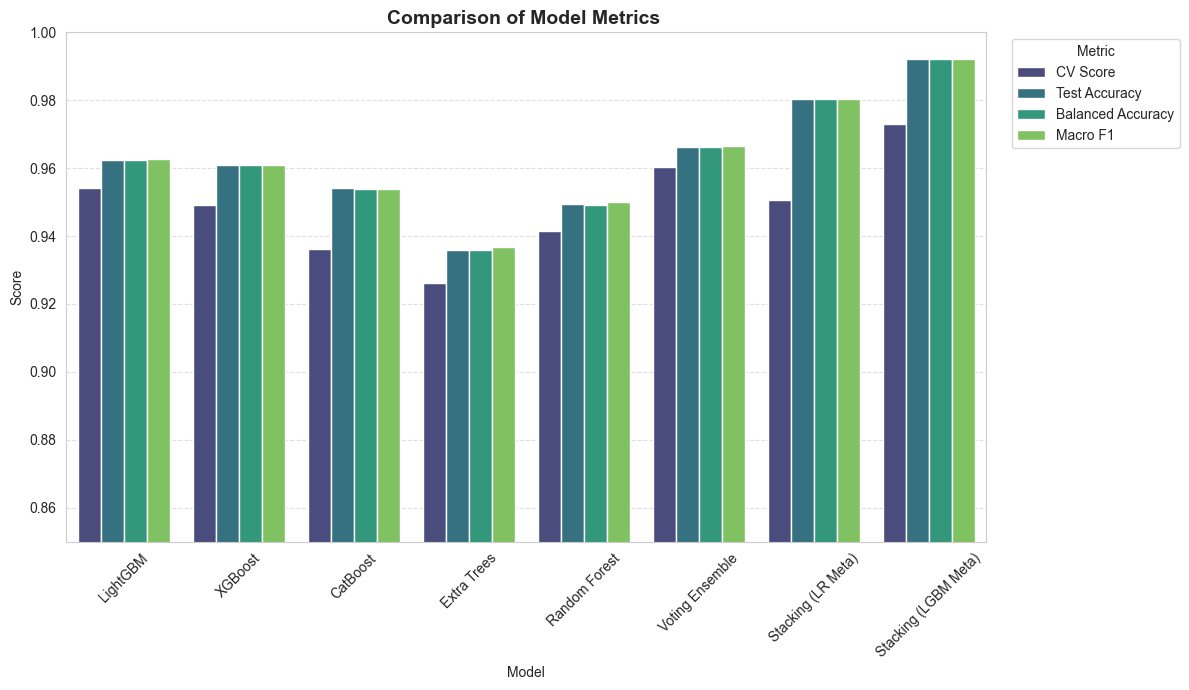

In [4]:
# ==============================================
# ✅ Final Ensemble Model Comparison – All Metrics in One Bar Plot
# ==============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Base model results ---
comparison_df = pd.DataFrame({
    "Model": ["LightGBM", "XGBoost", "CatBoost", "Extra Trees", "Random Forest"],
    "CV Score": [0.9541, 0.9491, 0.9363, 0.9263, 0.9416],
    "Test Accuracy": [0.9625, 0.9608, 0.9541, 0.9359, 0.9493],
    "Balanced Accuracy": [0.9625, 0.9608, 0.9540, 0.9358, 0.9492],
    "Macro F1": [0.9628, 0.9609, 0.9539, 0.9369, 0.9501]
})

# --- Ensemble models ---
ensembles = pd.DataFrame({
    "Model": [
        "Voting Ensemble", 
        "Stacking (LR Meta)", 
        "Stacking (LGBM Meta)"
    ],
    "CV Score": [0.9602, 0.9505, 0.9729],
    "Test Accuracy": [0.9662, 0.9804, 0.9921],
    "Balanced Accuracy": [0.9662, 0.9803, 0.9920],
    "Macro F1": [0.9666, 0.9804, 0.9920]
})

# --- Merge datasets ---
comparison_df = pd.concat([comparison_df, ensembles]).set_index("Model")

# --- Melt data to long format for grouped plotting ---
melted = comparison_df.reset_index().melt(id_vars="Model", 
                                          var_name="Metric", 
                                          value_name="Score")

# --- Plot setup ---
sns.set_style("whitegrid")
plt.figure(figsize=(12, 7))

# --- Grouped bar plot ---
sns.barplot(
    data=melted,
    x="Model",
    y="Score",
    hue="Metric",
    palette="viridis"
)

# --- Customize plot ---
plt.title("Comparison of Model Metrics ", fontsize=14, weight='bold')
plt.ylabel("Score")
plt.ylim(0.85, 1.0)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(title="Metric", bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [5]:
# ==============================================
# ✅ Final Ensemble Model Comparison – Save PNGs
# ==============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Base model results ---
comparison_df = pd.DataFrame({
    "Model": ["LightGBM", "XGBoost", "CatBoost", "Extra Trees", "Random Forest"],
    "CV Score": [0.9541, 0.9491, 0.9363, 0.9263, 0.9416],
    "Test Accuracy": [0.9625, 0.9608, 0.9541, 0.9359, 0.9493],
    "Balanced Accuracy": [0.9625, 0.9608, 0.9540, 0.9358, 0.9492],
    "Macro F1": [0.9628, 0.9609, 0.9539, 0.9369, 0.9501]
})

# --- Ensemble models ---
ensembles = pd.DataFrame({
    "Model": [
        "Voting Ensemble", 
        "Stacking (LR Meta)", 
        "Stacking (LGBM Meta)"
    ],
    "CV Score": [0.9602, 0.9505, 0.9729],
    "Test Accuracy": [0.9662, 0.9804, 0.9921],
    "Balanced Accuracy": [0.9662, 0.9803, 0.9920],
    "Macro F1": [0.9666, 0.9804, 0.9920]
})

# --- Merge ---
comparison_df = pd.concat([comparison_df, ensembles]).set_index("Model")

# --- Display the comparison table ---
print("\n Final Ensemble Performance Comparison:\n")
print(comparison_df.round(4))

# --- Define metrics for plotting ---
metrics = ["CV Score", "Test Accuracy", "Balanced Accuracy", "Macro F1"]

# --- Plot setup ---
sns.set_style("whitegrid")

# --- Generate and save each plot ---
saved_files = []
for metric in metrics:
    plt.figure(figsize=(8, 6))
    sorted_df = comparison_df.sort_values(by=metric, ascending=False)
    
    sns.barplot(
        x=sorted_df.index,
        y=sorted_df[metric],
        hue=sorted_df.index,
        palette="viridis",
        legend=False
    )
    
    plt.title(f"{metric} Comparison", fontsize=14, weight='bold')
    plt.ylabel(metric)
    plt.ylim(0.85, 1.0)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    
    # --- Save plot as PNG ---
    filename = f"{metric.replace(' ', '_').lower()}_comparison.png"
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.close()
    
    saved_files.append(filename)

# --- Print saved file names ---
print("\n✅Saved bar plots as PNG files:")
for file in saved_files:
    print(" -", file)



 Final Ensemble Performance Comparison:

                      CV Score  Test Accuracy  Balanced Accuracy  Macro F1
Model                                                                     
LightGBM                0.9541         0.9625             0.9625    0.9628
XGBoost                 0.9491         0.9608             0.9608    0.9609
CatBoost                0.9363         0.9541             0.9540    0.9539
Extra Trees             0.9263         0.9359             0.9358    0.9369
Random Forest           0.9416         0.9493             0.9492    0.9501
Voting Ensemble         0.9602         0.9662             0.9662    0.9666
Stacking (LR Meta)      0.9505         0.9804             0.9803    0.9804
Stacking (LGBM Meta)    0.9729         0.9921             0.9920    0.9920

✅Saved bar plots as PNG files:
 - cv_score_comparison.png
 - test_accuracy_comparison.png
 - balanced_accuracy_comparison.png
 - macro_f1_comparison.png


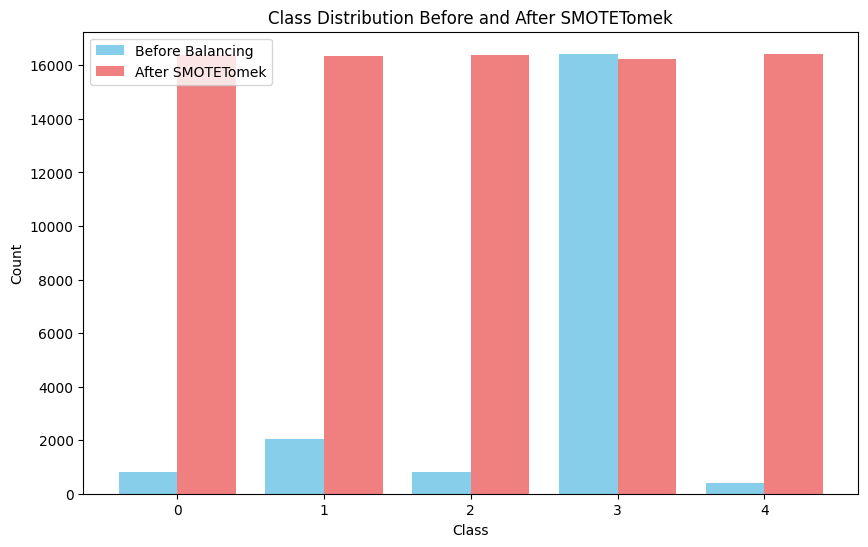

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

# Data before balancing
before_balancing = pd.Series({
    3: 16432,
    1: 2054,
    2: 821,
    0: 821,
    4: 410
}, name="count")

# Data after SMOTETomek
after_balancing = pd.Series({
    4: 16411,
    0: 16388,
    2: 16383,
    1: 16339,
    3: 16241
}, name="count")

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Lighter colors for before balancing
ax.bar(before_balancing.index - 0.2, before_balancing.values, width=0.4, label='Before Balancing', color='skyblue')

# Lighter colors for after balancing
ax.bar(after_balancing.index + 0.2, after_balancing.values, width=0.4, label='After SMOTETomek', color='lightcoral')

ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('Class Distribution Before and After SMOTETomek')
ax.legend()

# Save the plot
plt.savefig('class_distribution.png')
plt.show()
